<a href="https://colab.research.google.com/github/cybunayog/stylegan2/blob/master/StyleGan2_v17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prep
## Save dataset into Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Clone Repo and install resize module

In [2]:
# Clone the repo (DO THIS ONCE)
!git clone https://github.com/cybunayog/stylegan2.git

# Install python-resize-image (RUN ONCE AND COMMENT)
!pip install python-resize-image

Cloning into 'stylegan2'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 136 (delta 2), reused 0 (delta 0), pack-reused 127
Receiving objects: 100% (136/136), 694.48 KiB | 19.84 MiB/s, done.
Resolving deltas: 100% (60/60), done.


## Tensorflow & GPU Check

In [3]:
%tensorflow_version 1.x
import tensorflow as tf
import os

# Verify if repo has been cloned
print("List directory")
!ls /content/stylegan2
print("\n")

# Make sure you use tensoflow version 1
print('Tensorflow version: {}'.format(tf.__version__) )

# Use '%' prefix in colab or run this in command line
%cd /content/stylegan2

# Test if CPU, GPU, and Tensorflow is recognized
!nvcc test_nvcc.cu -o test_nvcc -run
print('Tensorflow version: {}'.format(tf.__version__) )
!nvidia-smi -L
print('GPU Identified at: {}'.format(tf.test.gpu_device_name()))

TensorFlow 1.x selected.
List directory
dataset_tool.py  LICENSE.txt		 README.md	   run_training.py
dnnlib		 metrics		 run_generator.py  StyleGan2_v17.ipynb
Dockerfile	 pretrained_networks.py  run_metrics.py    test_nvcc.cu
docs		 projector.py		 run_projector.py  training


Tensorflow version: 1.15.2
/content/stylegan2
CPU says hello.
GPU says hello.
Tensorflow version: 1.15.2
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-a5bb04e1-d574-4649-9fae-e7d4eb9b4bb5)
GPU Identified at: /device:GPU:0


## Extract Custom Dataset from G Drive to Colab

In [4]:
# Run once
## There are 63565 images/seeds
!unrar x "/content/drive/MyDrive/Colab Notebooks/animeDataset.rar" "/content/custom_data/"

Streaming output truncated to the last 5000 lines.
Extracting  /content/custom_data/images/62765_2019.jpg                    92%  OK 
Extracting  /content/custom_data/images/62766_2019.jpg                    92%  OK 
Extracting  /content/custom_data/images/62767_2019.jpg                    92%  OK 
Extracting  /content/custom_data/images/62768_2019.jpg                    92%  OK 
Extracting  /content/custom_data/images/62769_2019.jpg                    92%  OK 
Extracting  /content/custom_data/images/6276_2003.jpg                     92%  OK 
Extracting  /content/custom_data/images/62770_2019.jpg                    92%  OK 
Extracting  /content/custom_data/images/62771_2019.jpg                    93%  OK 
Extracting  /content/custom_data/images/62772_2019.jpg                    93%  OK 
Extracting  /content/custom_data/images/62773_2019.jpg                    93%  OK 
Extracting  /content/custom_d

## Resize Images to prep for Training

In [5]:
import dnnlib
import dnnlib.tflib as tflib
import PIL.Image
from PIL import Image
from tqdm import tqdm
import cv2
from resizeimage import resizeimage

# From the custom dataset
path = '/content/custom_data/images/'
for filename in tqdm(os.listdir(path), desc='reading images...'):
  image = Image.open(path+filename)
  image = image.resize((64, 64))
  image.save(path+filename, image.format)

reading images...: 100%|██████████| 63565/63565 [00:49<00:00, 1288.81it/s]


## Convert Custom Images to tfrecords

This is required for training the stylegan

In [6]:
! python /content/stylegan2/dataset_tool.py create_from_images /content/stylegan2/datasets/anime-dataset /content/custom_data/images/

Loading images from "/content/custom_data/images/"
Creating dataset "/content/stylegan2/datasets/anime-dataset"
/content/stylegan2/dataset_tool.py:86: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  'data': tf.train.Feature(bytes_list=tf.train.BytesList(value=[quant.tostring()]))}))
Added 63565 images.


# Train Dataset & Create Models
### This usually takes the longest
### Based on total kimg (iterations or epochs): The higher kimg, the longer it takes for the model to train

#### Current training: 480 iterations

In [ ]:
# Recommended to go 10000 kimg for better results
! python /content/stylegan2/run_training.py --num-gpus=1 --data-dir=/content/stylegan2/datasets --config=config-f --dataset=anime-dataset --result-dir=/content/results --metrics=None --total-kimg=1000 #--mirror-augment=true 

# Using generated model
## Get pretrained model from personal drive
### I was only able to iterate around 400 kimg/epochs

In [7]:
!cp '/content/drive/MyDrive/Colab Notebooks/pretrained-models/network-snapshot-000000.pkl' .
!cp '/content/drive/MyDrive/Colab Notebooks/pretrained-models/network-snapshot-000160.pkl' .
!cp '/content/drive/MyDrive/Colab Notebooks/pretrained-models/network-snapshot-000320.pkl' .
!cp '/content/drive/MyDrive/Colab Notebooks/pretrained-models/network-snapshot-000480.pkl' .

### Get metrics
#### Inception Distance, Precision & Recall

In [ ]:
! python /content/stylegan2/run_metrics.py --data-dir=/content/stylegan2/datasets --network=/content/stylegan2/network-snapshot-000480.pkl --metrics=fid50k,pr50k3 --dataset=anime-dataset

Local submit - run_dir: results/00000-run-metrics
dnnlib: Running run_metrics.run() on localhost...
Evaluating metrics "fid50k,pr50k3" for "/content/stylegan2/network-snapshot-000480.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


## Project Generated & Real Images
### Get trained model

In [ ]:
! python /content/stylegan2/run_projector.py project-generated-images --network=/content/stylegan2/network-snapshot-000480.pkl --seeds=1,3,5 

## Display images setup

In [ ]:
import pretrained_networks
network_pkl = '/content/stylegan2/network-snapshot-000480.pkl'

_G, _D, Gs = pretrained_networks.load_networks(network_pkl)

## Generate Random Vectors

In [ ]:
import numpy as np

def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:])
        zs.append(z)
    return zs

## Helper Functions to display results

In [ ]:
import dnnlib
import dnnlib.tflib as tflib
import PIL.Image
from tqdm import tqdm

# Get tf noise variables, for the stochastic variation
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

# Trunctation psi value needed for the truncation trick
def generate_images(zs, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if not isinstance(truncation_psi, list):
        truncation_psi = [truncation_psi] * len(zs)
        
    imgs = []
    for z_idx, z in tqdm(enumerate(zs)):
        Gs_kwargs.truncation_psi = truncation_psi[z_idx]
        noise_rnd = np.random.RandomState(1) # fix noise
        tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
        imgs.append(PIL.Image.fromarray(images[0], 'RGB'))
        
    # Return array of PIL.Image
    return imgs

def generate_images_from_seeds(seeds, truncation_psi):
    return generate_images(generate_zs_from_seeds(seeds), truncation_psi)

### Pre-Trained Results


0it [00:00, ?it/s]
9it [00:00, 69.37it/s]

[884701 903213 762686 744311 806893 528663 518212 685724   7284]


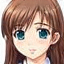

In [ ]:
# generate 9 random seeds
seeds = np.random.randint(1000000, size=9)
print(seeds)

zs = generate_zs_from_seeds(seeds)
imgs = generate_images(zs, 0.5)
imgs[0]

## Pre-Trained Results Loop

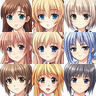

In [ ]:
from math import ceil

def createImageGrid(images, scale=0.25, rows=1):
  w, h = images[0].size
  w = int(w * scale)
  h = int(h * scale)
  height = rows * h
  cols = ceil(len(images) / rows)
  width = cols * w
  canvas = PIL.Image.new('RGBA', (width, height), 'white')

  for i, img in enumerate(images):
    img = img.resize((w, h), PIL.Image.ANTIALIAS)
    canvas.paste(img, (w * (i % cols), h * (i // cols)))
  
  return canvas

createImageGrid(imgs, scale=0.5 ,rows=3)

## Interpolate between two values of the Z vectors


In [ ]:
def interpolate(zs, steps):
  out = []
  for i in range(len(zs) - 1):
    for index in range(steps):
      fraction = index / float(steps)
      out.append(zs[i + 1] * fraction + zs[i] * (1 - fraction))
  return out

## Results of Interpolation


0it [00:00, ?it/s]
14it [00:00, 71.70it/s]


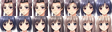

In [ ]:
seeds = np.random.randint(10000000, size=3)
zs = generate_zs_from_seeds(seeds)
imgs = generate_images(interpolate(zs, 7), 0.5)
createImageGrid(imgs, rows=2)

## Animation




In [ ]:
import scipy
import moviepy.editor

grid_size = [3,3]
duration_sec = 5
smoothing_sec = 1.0
image_zoom = 1
fps = 15
random_seed = np.random.randint(0, 10000)

num_frames = int(np.rint(duration_sec * fps))
random_state = np.random.RandomState(random_seed)

# Generate latent vectors
shape = [num_frames, np.prod(grid_size)] + Gs.input_shape[1:]
all_latents = random_state.randn(*shape).astype(np.float32)
all_latents = scipy.ndimage.gaussian_filter(all_latents, [smoothing_sec * fps] + [0] * len(Gs.input_shape), mode='wrap')
all_latents /= np.sqrt(np.mean(np.square(all_latents)))

def create_image_grid(images, grid_size=None):
  assert images.ndim == 3 or images.ndim == 4
  num, img_h, img_w, channels = images.shape

  if grid_size is not None:
    grid_w, grid_h = tuple(grid_size)
  else:
    grid_w = max(int(np.ceil(np.sqrt(num))), 1)
    grid_h = max((num - 1) // grid_w + 1, 1)

  grid = np.zeros([grid_h * img_h, grid_w * img_w, channels], dtype=images.dtype)
  for idx in range(num):
    x = (idx % grid_w) * img_w
    y = (idx // grid_w) * img_h
    grid[y : y + img_h, x : x + img_w] = images[idx]
  return grid

# Frame generation func for moviepy
def make_frame(t):
  frame_idx = int(np.clip(np.round(t * fps), 0, num_frames - 1))
  latents = all_latents[frame_idx]
  fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
  images = Gs.run(latents, None, truncation_psi=0.7,
                  randomize_noise=False, output_transform=fmt,
                  minibatch_size=16)
  
  grid = create_image_grid(images, grid_size)
  if image_zoom > 1:
    grid = scipy.ndimage.zoom(grid, [image_zoom, image_zoom, 1], order=0)
  if grid.shape[2] == 1:
    grid = grid.repeat(3, 2)
  return grid

# Generate the vid
video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)

video_clip.write_gif('random_grid_%s.gif' % random_seed, fps=fps)


[MoviePy] Building file random_grid_541.gif with imageio



 99%|█████████▊| 75/76 [00:12<00:00,  6.04it/s]


AttributeError: ignored